# BARK NEURAL NETWORK USING PYTORCH
 I trained CNN network to classify images from the Bark Texture Dataset <br>
 The process mirrors a typical process for training a neural network as follows
 
 ### NOTE
 The file structure for the dataset should be such that every bark texture class has its individual folder



In [10]:
# Importing the libraries needed for loading,
# visualizing, training and measuring model performance

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torchvision


In [11]:
# Checking GPU availability, if availble move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
def dataLoader(files):
        
    #Data Augmenetation and tranformation into a torch tensor float
    transform = transforms.Compose([transforms.Resize((256, 256)),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                    transforms.RandomHorizontalFlip(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                   ])
    
    #Loading the training set
    dataset = datasets.ImageFolder(files, transform)  
    
    return dataset

In [13]:
dataset = dataLoader("./bark")

In [14]:
#The data spliting approach employed here is as follows
#The dataset is first split into two (70% training dataset and 30% validation set)
#The validation set is further splitted into ( 50% test and 50% validation set )
# The Goal for this splitting approach is to help validate the model in other to determine when to stop training


#percentage of dataset to be used as training,validation and test sets
test_size = 0.5
validation_size=0.3
batch_size= 30


#Indices that will be used for spliting the dataset 
total_sample = len(dataset)    
indices = list(range(total_sample))
np.random.shuffle(indices)
split = int(np.floor(validation_size * total_sample))
train_ind, valid_test = indices[split:], indices[:split]
test_split = int(np.floor(test_size * len(valid_test)))
valid_ind, test_ind = valid_test[test_split:], valid_test[:test_split]

# samplers for obtaining training, test and validation batches
train_sampler = SubsetRandomSampler(train_ind)
valid_sampler = SubsetRandomSampler(valid_ind)
test_sampler = SubsetRandomSampler(test_ind)    

#Here the loaders are loaded with a batch size of 30 along side the samplers defined above
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)    
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)    
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)    

#The random sampling technique employed above is aimed at avoiding bais in the selection of input 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


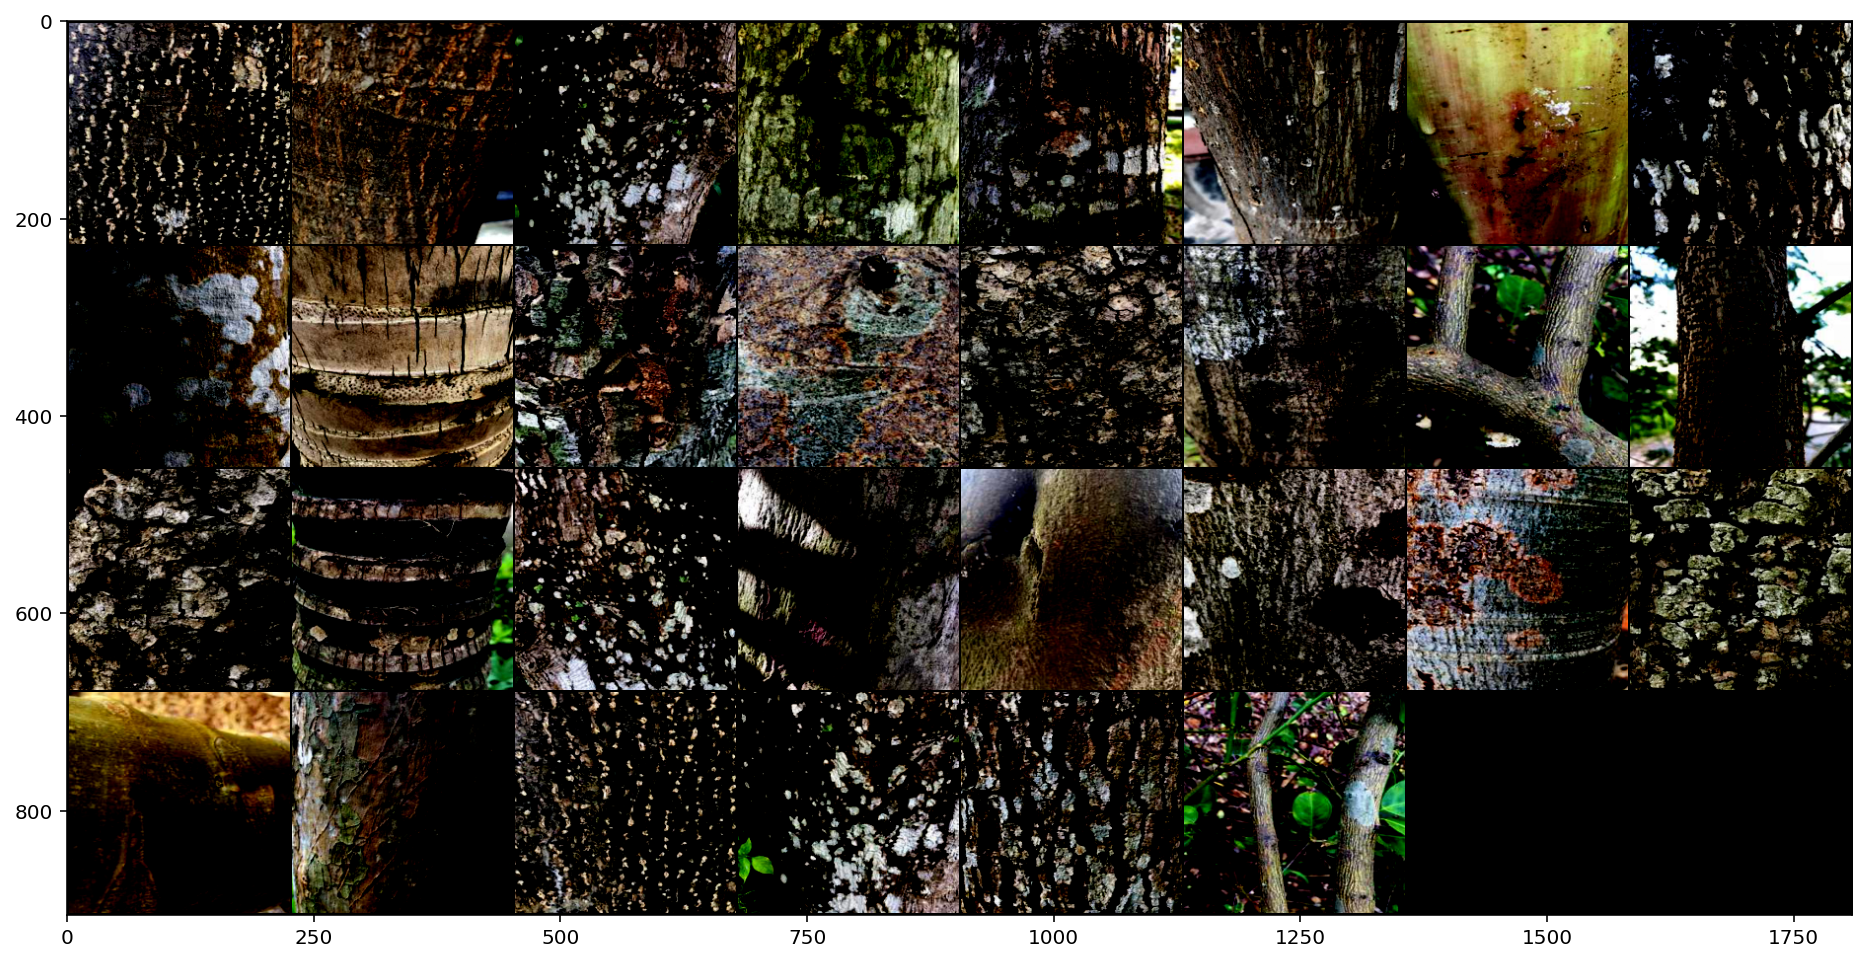

In [15]:
# Display image for visualization

images, labels = next(iter(train_loader))
plt.figure(figsize=(16,32))
grid_imgs = torchvision.utils.make_grid(images[:32])
np_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_imgs, (1,2,0)))

In [30]:
#The CNN architecture 
# Here the CNN takes a  224 x 224 x3 input image tensors  which serves as input into three convolutional layers
# And one pooling layer. The result which is a set of feature map is flattened and passed as input into the fully connected layer
# From the result we get class score for each bark texture which helps in predicting the image

class nn_model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,100, 3)  #cnn with 224x224x3 image tensor
        self.conv2 = nn.Conv2d(100, 200, 3) 
        self.conv3 = nn.Conv2d(200, 400, 3)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)       
                
        self.fc1 = nn.Linear(270400, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 50)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))      
        return x

model = nn_model()

In [31]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 100, 222, 222]           2,800
         MaxPool2d-2        [-1, 100, 111, 111]               0
            Conv2d-3        [-1, 200, 109, 109]         180,200
         MaxPool2d-4          [-1, 200, 54, 54]               0
            Conv2d-5          [-1, 400, 52, 52]         720,400
         MaxPool2d-6          [-1, 400, 26, 26]               0
            Linear-7                  [-1, 500]     135,200,500
            Linear-8                   [-1, 50]          25,050
Total params: 136,128,950
Trainable params: 136,128,950
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 79.90
Params size (MB): 519.29
Estimated Total Size (MB): 599.76
----------------------------------------------------------------


In [32]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [33]:
# Training function

def training_model (epochs, train_loader, valid_loader, criterion, optimizer):
 
    max_loss = np.Inf # track change in validation loss
    train_loss = 0.0
    valid_loss = 0.0

    for epoch in range(epochs):
              
        model.train()
        
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)            
            optimizer.zero_grad()
            pred_output = model(data)
            loss = criterion(pred_output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
           
        model.eval()
        
        for data, target in valid_loader:
            val_output = model(data)
            loss = criterion(val_output, target)
            valid_loss = loss.item()
        
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
        
        if valid_loss <= max_loss:
            print('saving best model with accuracy:  {:.6f}'.format(valid_loss))
            torch.save(model.state_dict(), 'barktexturemodel.pt')
            max_loss = valid_loss      
            
    

In [34]:
training_model(30,train_loader, validation_loader,criterion, optimizer)

Epoch: 0 	Training Loss: 3.880005 	Validation Loss: 0.135622
saving best model with accuracy:  0.13562240770884923
Epoch: 1 	Training Loss: 3.738255 	Validation Loss: 0.129454
saving best model with accuracy:  0.12945376123700822
Epoch: 2 	Training Loss: 3.490117 	Validation Loss: 0.128295
saving best model with accuracy:  0.12829464673995972
Epoch: 3 	Training Loss: 3.224464 	Validation Loss: 0.132677
Epoch: 4 	Training Loss: 2.915661 	Validation Loss: 0.122894
saving best model with accuracy:  0.12289417641503471


In [35]:
model.load_state_dict(torch.load('barktexturemodel.pt'))

<All keys matched successfully>

In [36]:
# Test function: This function is used to pass unseen data to determine if the model trained above can make generalization 
def pred (model, testloader):    
    test_loss = 0.0
    correct = 0
    total = 0
    
    model.eval()    
    with torch.no_grad():
        for data, target in testloader:
            data = data.to(device)
            target = target.to(device) 
            pred_output= model(data)
            loss = criterion(pred_output, target)
            test_loss += loss.item()
            v,predicted = torch.max(pred_output.data, 1)              
            total += target.size(0)          
            correct += (predicted == target).float().sum().item()
            
            print(
                "Test Accuracy on the {} test images: {} %".format(
                    total, 100 * correct / total
                )
            )
               

In [37]:
pred(model, test_loader)

Test Accuracy on the 30 test images: 30.0 %
Test Accuracy on the 60 test images: 28.333333333333332 %
Test Accuracy on the 90 test images: 23.333333333333332 %
Test Accuracy on the 120 test images: 22.5 %
Test Accuracy on the 150 test images: 21.333333333333332 %
Test Accuracy on the 180 test images: 20.555555555555557 %
Test Accuracy on the 210 test images: 20.952380952380953 %
Test Accuracy on the 240 test images: 21.25 %
Test Accuracy on the 270 test images: 21.48148148148148 %
Test Accuracy on the 300 test images: 22.0 %
Test Accuracy on the 330 test images: 21.818181818181817 %
Test Accuracy on the 360 test images: 22.5 %
Test Accuracy on the 390 test images: 23.076923076923077 %
Test Accuracy on the 420 test images: 22.857142857142858 %
Test Accuracy on the 450 test images: 22.22222222222222 %
Test Accuracy on the 480 test images: 22.5 %
Test Accuracy on the 510 test images: 21.764705882352942 %
Test Accuracy on the 540 test images: 21.666666666666668 %
Test Accuracy on the 570 t